# **TRANSFER LEARNING**

## **1. Introduction:**

Mô hình dự đoán không chuân xác mặc dù đã áp dụng những kiến trúc phức tạp được xem là SOTA.

Quá trình huấn luyện một mô hình AI trên bộ dữ liệu của mình ngay từ đầu đoi khi dẫn tới kết quả không thực sự chuẩn xác dẫn tới lãng phí tài nguyên tính toán.

Phương pháp được xây dựng dựa trên ý tưởng huyển giao tri thức đã được học từ những mô hình trước đó, đó là transfer learning

### **1.1 Nguyên nhân mô hình dự báo kém** 

Bỏ qua những vấn đề liên quan đến sự cố dữ liệu như gán nhãn sai, ảnh mập mờ, bị che khuất, vân vân,…. Thông thường mô hình dự báo kém là do:

- **Dữ liệu nhỏ, không đại diện:** Bộ dữ liệu quá nhỏ không học được các đặc trưng tổng quát để áp dụng vào phân loại.

- **Mô hình mất cân băng dữ liệu:** Khi mô hình mất cân băng dữ liệu thì việc dự đoán các mẫu thuộc nhóm thiểu số khó khăn hơn. Tham khảo [Bài 24 - Mất cân bằng dữ liệu (imbalanced dataset)](https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html) 
- **Kiến trúc mô hình quá phức tạp:** Bộ dữ liệu đơn giản, mô hình phức tạp thường xảy ra overfitting.
- **Quá trình tối ưu hóa gặp khó khăn:** Có thể bạn đã thiết lập learning rate chưa tốt nên khiến mô hình huấn luyện lâu hội tụ hoặc chưa đạt tới điểm global optimal. Khi đó bạn có thể cân nhắc thay đổi phương pháp cập nhật gradient descent và thiết lập schedule learning rate. Trên `tensorflow.keras` chúng ta có thể thiết lập schedule learning thông qua CheckPoint như sau:

In [ ]:
import tensorflow as tf

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
your_model.fit(data, labels, epochs=100, callbacks=[callback],
          validation_data=(val_data, val_labels))

### **1.2 Vai trò của transfer learning**

#### **1.2.1 Chuyển giao tri thức**

Các pretrained-model có chất lượng tốt và độ chính xác cao. Hầu như mọi domain đều có thể tìm kiếm được các pretrained-model.

Một mô hình đã có khả năng tận dụng lại các tri thức đã huấn luyện trước đó và cải thiện lại trên tác vụ phân loại của nó.

#### **1.2.2 Cải thiện accuracy và tiết kiệm chi phí huấn luyện**

Ví dụ trong bài toán phân loại chó và mèo. Nếu huấn luyện từ đầu, bạn sẽ tốn nhiều epochs huấn luyện hơn để đạt được độ chính xác cao. Tuy nhiên nếu bạn biết tận dụng lại các pretrained-model thì sẽ cần ít epochs huấn luyện hơn để đạt được một độ chính xác mong đợi. Thậm chí độ chính xác có thể lớn hơn so với khi không áp dụng transfer learning.

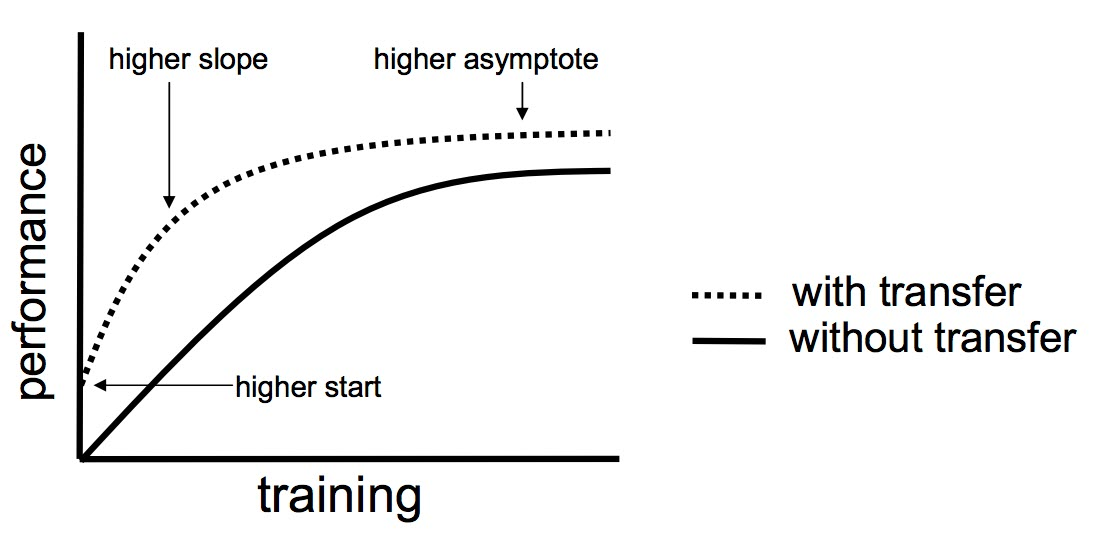

Từ đồ thị ta có thể thấy sử dụng transfer learning sẽ mang lại 3 lợi thế chính:

Có điểm khởi đầu của accuracy tốt hơn (higher start).
Accuracy có tốc độ tăng nhanh hơn (higher slope).
Đường tiệm cận của độ chính xác tối ưu cao hơn (higher asymptote).

## **2. Transfer Learning**

### **2.1 Ví dụ về transfer learning**

Quá trình áp dụng tri thức đã được học từ một mô hình trước sang bài toán hiện tại được gọi là transfer learning.

Để hiểu rõ hơn, mình lấy ví dụ:

Trong bài toán dự báo dog and cat. Chúng ta có 2 nhãn cần phân loại là dog, cat và cả 2 nhãn này đều xuất hiện trong một bộ dữ liệu imagenet. Như vậy chúng ta kì vọng rằng có thể tận dụng lại các weights từ pretrained-model trên bộ dữ liệu imagenet để huấn luyện lại bài toán nhanh hơn, chuẩn xác hơn.

### **2.2 Kiến trúc mô hình sử dụng transfer learning**

Như chúng ta đã biết các layers CNN về bản chất là một feature extractor mà mỗi một layer CNN sẽ có tác dụng trích lọc đặc trưng theo những level khác nhau.

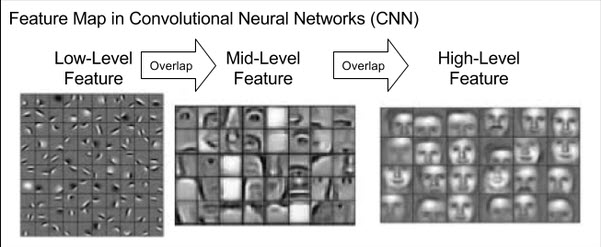

**Hình 2:** Các đặc trưng học được từ mạng CNN. Ở những Convolutional Layers đầu tiên, các bộ lọc phát hiện được các chi tiết chung dưới dạng các nét ngang, dọc và các cạnh của ảnh. Đây là những đặc trưng bậc thấp (low level feature) và khá chung chung. Chúng ta chưa thể nhận biết được vật thể dựa trên những đường nét này. Ở những Convolutional Layers cuối cùng là những đặc trưng bậc cao (high level feature) được tổng hợp từ đặc trưng bậc thấp. Đây là những đặc trưng tốt và có sức mạnh phân loại các classes.

Quá trình transfer learning sẽ tận dụng lại các đặc trưng được học từ những pretrained-model.

- **Pharse 1:** 
Là một mạng Base Network có tác dụng trích lọc đặc trưng được cấu tạo từ các Convolutional 2D Layers. Base Network sẽ được trích xuất từ một phần của pretrained-model sau khi loại bỏ các top fully connected layers. Để dễ hình dung mình giả định model pretrained được sử dụng là VGG16, một kiến trúc khá tốt được google phát triển vào năm 2014. Điểm cải tiến của VGG16 so với các kiến trúc CNN trước đó là sử dụng nhiều Convolutional 2D Layers nối tiếp nhau. Cụ thể các layers có cấu trúc [[Conv]_n-MaxPool]_m thay vì [Conv-MaxPool]_m, với m, n là tần suất xuất hiện của các khối mạng được lặp lại bao bọc trong ngoặc vuông.

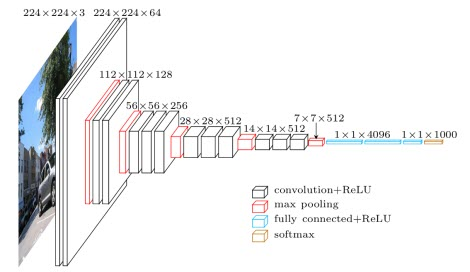

**Hình 3:** Kiến trúc mạng VGG16 được sử dụng là base network trong transfer learning

**Pharse 2**: Là các Fully Connected Layers giúp giảm chiều dữ liệu và tính toán phân phối xác suất ở output. Bản chất Fully Connected Layers chính là một mạng MLP (Multiple Layer Perceptron), một kiến trúc nguyên thủy nhất của thuật toán neural network. Số lượng các units ở output chính bằng với số lượng classes của bài toán phân loại. Các hệ số của fully connected layers sẽ được khởi tạo một cách ngẫu nhiên.

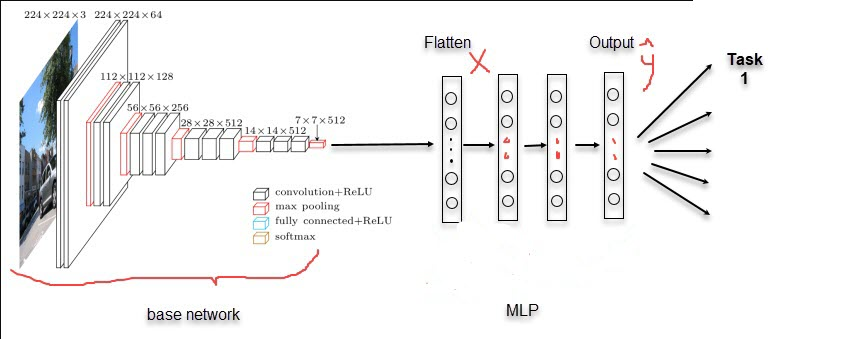

**Hình 4:** Kiến trúc base network kết hợp với fully connected layers.

Quá trình khởi tạo mô hình chúng ta sẽ tận dụng lại các weight của base_network. Dữ liệu ảnh sau khi đi qua base_network sẽ tạo ra những đặc trưng tốt, những đặc trưng này chính là đầu vào input $X$ cho mạng MLP để dự báo $y$. Hệ số $W$ và $b$ được khởi tạo ngẫu nhiên. Các hệ số của base network được load lại từ pretrain model.

Để dễ hình dung các bước và đồng thời kiểm nghiệm hiệu quả của transfer learning, chúng ta cùng thực hành trên bộ dữ liệu dog and cat.

## **3. Thực hành**

In [2]:
pwd

'c:\\Users\\Chi Khang\\Documents\\Internship\\W3'

In [3]:
!git clone https://github.com/ardamavi/Dog-Cat-Classifier.git
%cd Dog-Cat-Classifier

c:\Users\Chi Khang\Documents\Internship\W3\Dog-Cat-Classifier


Cloning into 'Dog-Cat-Classifier'...
Updating files:  66% (1114/1672)
Updating files:  67% (1121/1672)
Updating files:  68% (1137/1672)
Updating files:  69% (1154/1672)
Updating files:  70% (1171/1672)
Updating files:  71% (1188/1672)
Updating files:  72% (1204/1672)
Updating files:  73% (1221/1672)
Updating files:  74% (1238/1672)
Updating files:  75% (1254/1672)
Updating files:  76% (1271/1672)
Updating files:  77% (1288/1672)
Updating files:  78% (1305/1672)
Updating files:  79% (1321/1672)
Updating files:  80% (1338/1672)
Updating files:  81% (1355/1672)
Updating files:  82% (1372/1672)
Updating files:  83% (1388/1672)
Updating files:  84% (1405/1672)
Updating files:  85% (1422/1672)
Updating files:  86% (1438/1672)
Updating files:  87% (1455/1672)
Updating files:  88% (1472/1672)
Updating files:  89% (1489/1672)
Updating files:  90% (1505/1672)
Updating files:  91% (1522/1672)
Updating files:  92% (1539/1672)
Updating files:  93% (1555/1672)
Updating files:  94% (1572/1672)
Updati

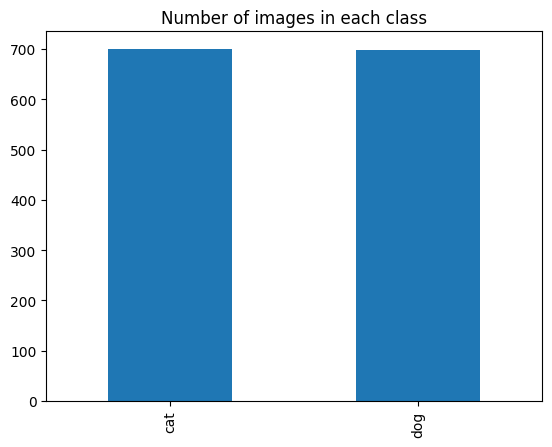

In [1]:
import pandas as pd
import glob2
import matplotlib.pyplot as plt

dogs = glob2.glob('Dog-Cat-Classifier\\Data\\Train_Data\\dog\\*.jpg')
dog_labels = ['dog']*len(dogs)
cats = glob2.glob('Dog-Cat-Classifier\\Data\\Train_Data\\cat\\*.jpg')
cat_labels = ['cat']*len(cats)

labels = dog_labels + cat_labels
image_links = dogs + cats

data = pd.DataFrame({'labels': labels, 'image_links':image_links})
data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()

### **3.1.1 Phân chia tập train/validation**


In [2]:
from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(image_links, labels, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))

images_train len: 1049, image_test shape: 350


## **3.1.2 Data Augmentation**

In [3]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames, 
                 labels, 
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2, 
                 normalize=True,
                 zoom_range=[0.8, 1],
                 rotation=15,
                 brightness_range=[0.8, 1],
                 shuffle=True):
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.index2class = index2class
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_filenames)/self.batch_size))
    
    def __getitem__(self, index):
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, y = self.__data_generation(all_filenames_temp)

        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Khởi tạo dữ liệu 
        for i,fn in enumerate(all_filenames_temp):
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            img_reshape = img.reshape(-1, 3)

            if self.normalize:
              mean = np.mean(img_reshape, axis=0)
              std = np.std(img_reshape, axis=0)
              img = (img-mean)/std

            if self.zoom_range:
              zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
            
            if self.rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(-self.rotation, self.rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img = cv2.warpAffine(img, RotMat, (w, h))

            if self.brightness_range:
              scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
              img = img*scale_bright
            
            label = 'dog' if 'dog' in fn else 'cat'
            label = self.index2class[label]
    
            X[i,] = img

            # Lưu class
            y[i] = label
        return X, y
    
dict_labels = {
    'dog' : 0,
    'cat' : 1
}

train_generator = DataGenerator(
    all_filenames = images_train,
    labels = y_label_train,
    batch_size = 32,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

val_generator = DataGenerator(
    all_filenames = images_val,
    labels = y_label_val,
    batch_size = 16,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range =[0.8, 1],
    shuffle = False
)

        

- **normalize**: Có thuẩn hóa mỗi một ảnh với theo phân phối chuẩn bằng cách trừ đi trung bình và chia cho phương sai toàn bộ các pixels tương ứng ở mỗi kênh.

- **zoom_range**: Là một khoảng giá trị phóng đại ảnh: [lower, upper]. Giá trị phóng đại của một ảnh sẽ được sinh ngẫu nhiên nằm trong khoảng zoom_range. Giá trị phóng đại này càng nhỏ thì ảnh sẽ càng được phóng to.

- **rotation**: Góc xoay ngẫu nhiên của một bức ảnh. Thông thường chỉ thiết lập từ 10-20 độ.

- **brightness_range**: Khoảng điều chỉnh độ sáng cho bức ảnh. Độ sáng sẽ là một giá trị ngẫu nhiên từ [minVal, maxVal].

## **3.1.3. Kiểm tra dữ liệu Augumentation**

In [4]:
check_aug=['Dog-Cat-Classifier\\Data\\Train_Data\\cat\\cat.100.jpg']*32

check_generator = DataGenerator(
    all_filenames = check_aug,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = 15,
    brightness_range = [0.5, 1.5],
    shuffle = False
)

In [5]:
X_batch, y_batch = check_generator.__getitem__(0)

print(X_batch.shape)
print(y_batch.shape)

(20, 224, 224, 3)
(20,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

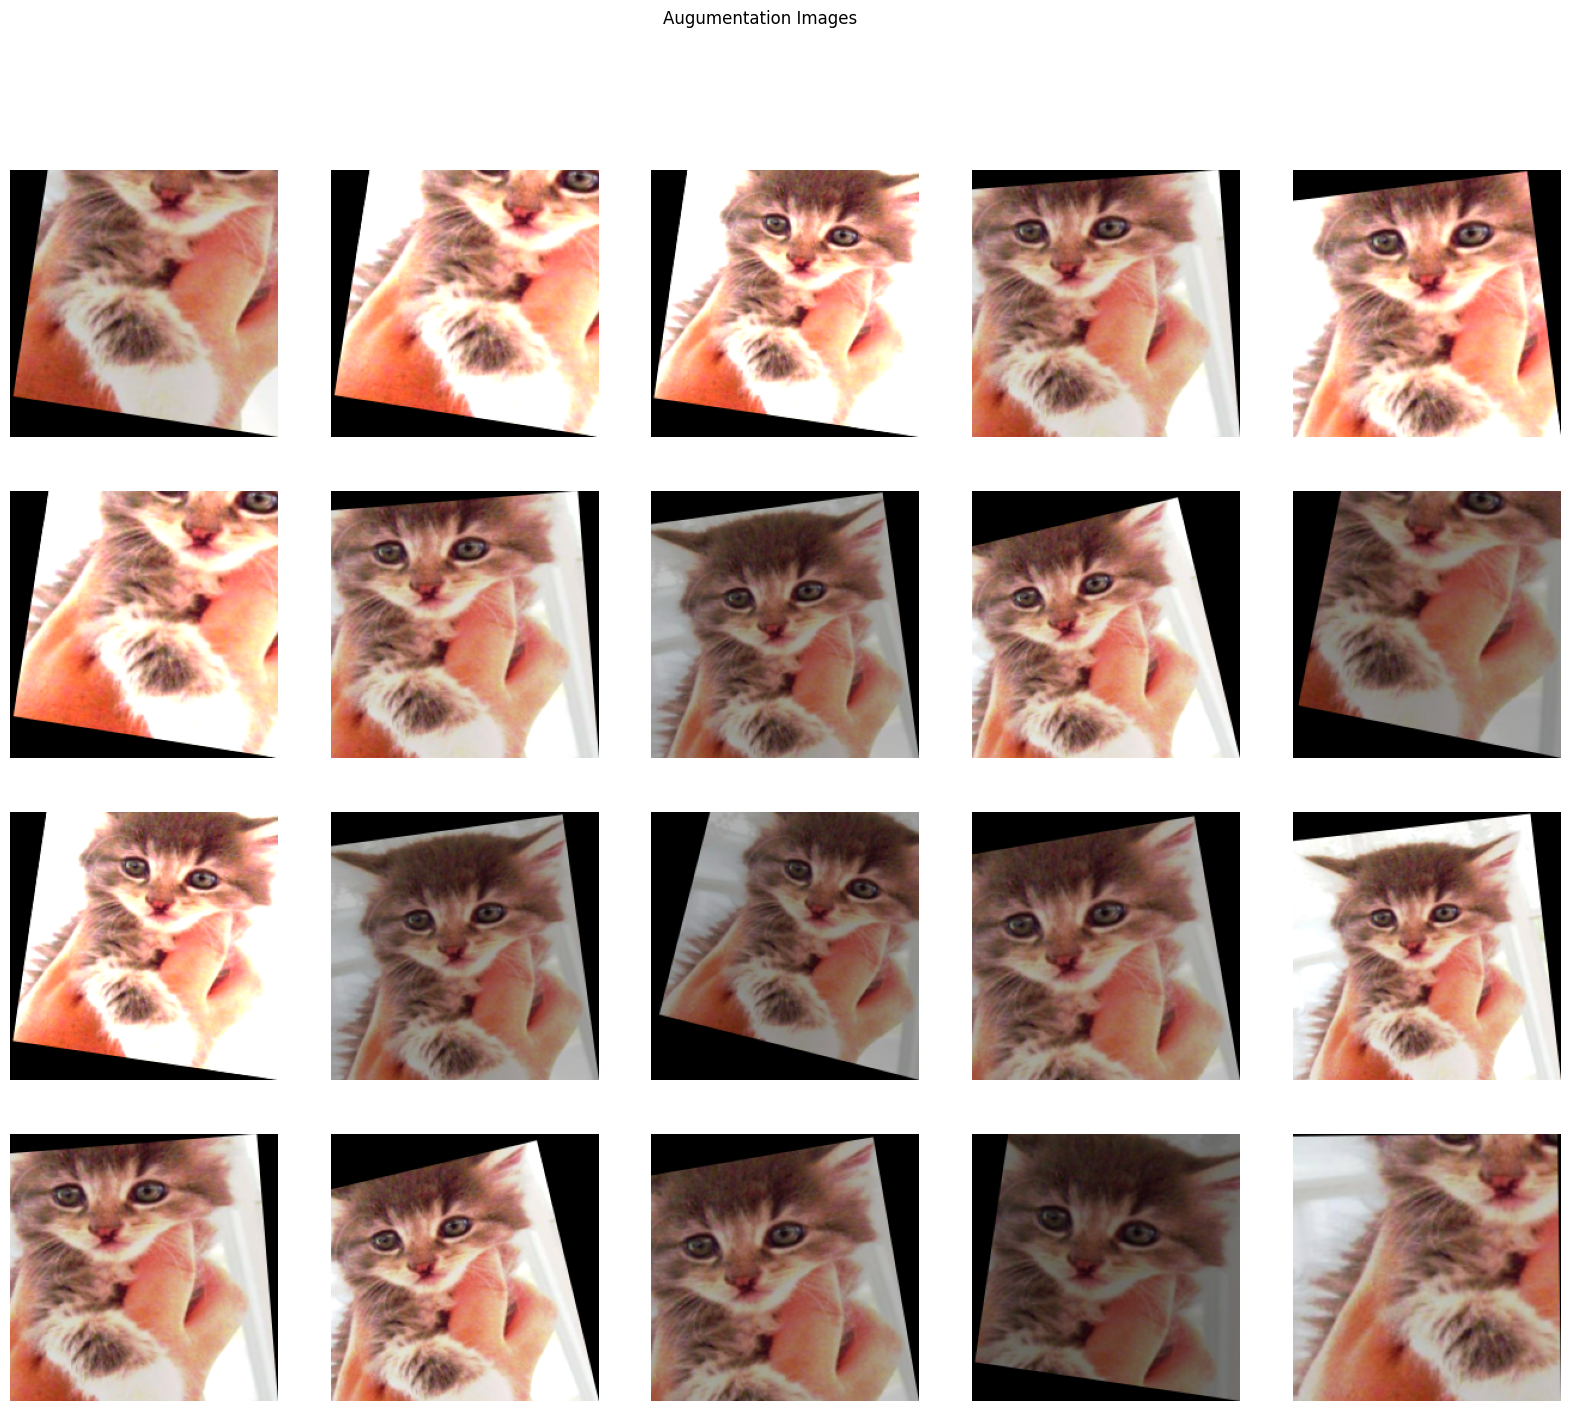

In [6]:
import matplotlib.pyplot as plt

# Khởi tạo subplot với 4 dòng 5 cột.
fg, ax = plt.subplots(4, 5, figsize=(20, 16))
fg.suptitle('Augumentation Images')

for i in np.arange(4):
  for j in np.arange(5):
    ax[i, j].imshow(X_batch[i + j + j*i]/255.0)
    ax[i, j].set_xlabel('Image '+str(i+j+j*i))
    ax[i, j].axis('off')
plt.show()

## **4. Training Model**

### **4.1 Khởi tạo model huấn luyện** 

In [7]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam


base_network = MobileNet(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
flat = Flatten()
den = Dense(1, activation='sigmoid')

model = Sequential([base_network, 
                    flat,
                    den])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1)                 50177     
                                                                 
Total params: 3,279,041
Trainable params: 3,257,153
Non-trainable params: 21,888
_________________________________________________________________


### **4.2 Warm up**

Warm up là quá trình để mô hình hội tụ nhanh hơn. Warm up sẽ đóng băng lại các layers CNN để cho hệ số của chúng không đổi và chỉ train lại trên các Fully Conntected Layers ở cuối cùng. Mục đích của warm up là giữ nguyên được các đặc trưng bậc cao (high-level) đã được học từ pretrained-model mà những đặc trưng này là tốt vì được huấn luyện trên bộ dữ liệu có kích thước lớn hơn và có độ chính xác cao hơn sao với khởi tạo hệ số ngẫu nhiên.

In [9]:
model.layers

In [8]:
# Frozen base_network
for layer in model.layers[:1]:
  layer.trainable = False

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))


Layer: <keras.engine.functional.Functional object at 0x0000024E0EEE4BB0> ; Trainable: False
Layer: <keras.layers.reshaping.flatten.Flatten object at 0x0000024E032BA760> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x0000024E0EEE4970> ; Trainable: True


In [13]:
import tensorflow as tf

model.fit(train_generator,
          #steps_per_epochs=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=1)

32/32 [==============================] - 159s 5s/step - loss: 0.9071 - accuracy: 0.8662 - val_loss: 25.1094 - val_accuracy: 0.4875


Giảm thiểu overfiting: 

- Mạng nơ ron có khả năng xấp xỉ được hầu hết các hàm số. Khi kiến trúc mạng càng phức tạp và bộ dữ liệu huấn luyện có kích thước nhỏ thì khả năng học được chính xác trên từng điểm dữ liệu sẽ rất tốt. Nhưng việc học này sẽ không tốt trên dữ liệu mới. Chúng ta có thể sử dụng Dropout Layer để giảm thiểu độ phức tạp trong kiến trúc của mô hình. Dropout sẽ làm nhiệm vụ cắt tỉa bớt một số kết nối Fully Connected.

- Để giảm thiểu mức độ phức tạp của hàm số chúng ta cũng có thể sử dụng các phương pháp hiệu chuẩn (regularization) bằng cách thêm vào loss function thành phần norm chuẩn Frobenius của ma trận hệ số các layers.

In [ ]:
from tensorflow.keras import regularizers
your_model.add(Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

## **5. Fine Tuning Model**

Mục đích chính của việc warm up model là để mô hình hội tụ nhanh hơn tới global optimal value

Sau khi mô hình đạt ngưỡng tối ưu trên các Fully Connected Layers, sẽ rất khó để tăng độ chính xác hơn nữa.

Cần phá băng (unfrozen) các layers của base network và huấn luyện mô hình trên toàn bộcác layers từ pretrained-model. Quá trình này được gọi là fine-tuning


In [15]:
for layer in model.layers[:1]:
  layer.trainable = True

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))


Layer: <keras.engine.functional.Functional object at 0x0000024E0EEE4BB0> ; Trainable: True
Layer: <keras.layers.reshaping.flatten.Flatten object at 0x0000024E032BA760> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x0000024E0EEE4970> ; Trainable: True


In [16]:
model.fit(train_generator,
          validation_data = val_generator,
          batch_size = 32,
          epochs = 5)

Epoch 1/5
32/32 [==============================] - 146s 5s/step - loss: 1.0667 - accuracy: 0.8779 - val_loss: 4.2291 - val_accuracy: 0.8185
Epoch 2/5
32/32 [==============================] - 137s 4s/step - loss: 1.0377 - accuracy: 0.8730 - val_loss: 3.4846 - val_accuracy: 0.8363
Epoch 3/5
32/32 [==============================] - 139s 4s/step - loss: 0.3627 - accuracy: 0.9121 - val_loss: 6.2688 - val_accuracy: 0.8244
Epoch 4/5
32/32 [==============================] - 140s 4s/step - loss: 0.2521 - accuracy: 0.9502 - val_loss: 3.7577 - val_accuracy: 0.8542
Epoch 5/5
32/32 [==============================] - 138s 4s/step - loss: 0.2828 - accuracy: 0.9375 - val_loss: 2.3116 - val_accuracy: 0.8958


## **6. Kinh nghiệm transfer learnning**




### **6.1 Transfer learning theo kích thước dữ liệu** 

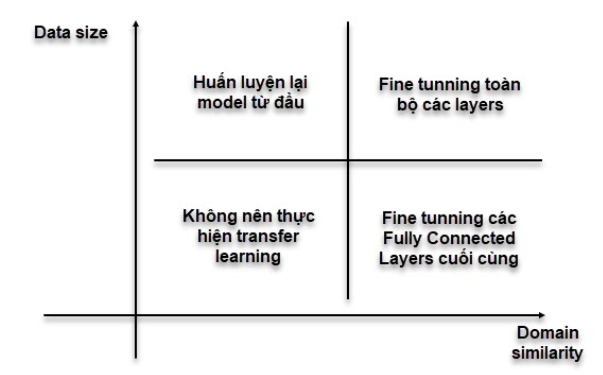

- Đối với dữ liệu nhỏ: Train lại toàn bộ các layers sẽ làm mất đi các đặc trưng đã được học từ model pretrained và dẫn tới mô hình dự báo sẽ không chính xác. Chúng ta chỉ nên train lại các fully connected layers cuối.

- Đối với dữ liệu lớn và giống domain: Có thể train lại model trên toàn bộ layers. Nhưng để quá trình huấn luyện nhanh hơn thì chúng ta sẽ thực hiện bước khởi động (warm up) và sau đó mới fine tuning lại mô hình.

- Đối với dữ liệu lớn và khác domain: Chúng ta nên huấn luyện lại model từ đầu vì pretrain-model không tạo ra được các đặc trưng tốt cho dữ liệu khác domain.

### **6.2. Khi nào thực hiện transfer learning**

- Chỉ nên transfer learning giauwx 2 mô hình có cùng domain
- Dữ liệu huấn luyện pretrained-model A phải lớn hơn so với mô hình B. 
- Pretrained-model A phải là mô hình có phẩm chất tốt mới tạo ra được các đặc truwg tốt.

## **7. References:**

1. [Transfer Learning - phamdinhkhanhblog](https://phamdinhkhanh.github.io/2020/04/15/TransferLearning.html)